In [1]:
!pip freeze | grep "qiskit"

qiskit==0.44.0
qiskit-aer==0.12.0
qiskit-ignis==0.7.1
qiskit-nature==0.6.2
qiskit-terra==0.25.0


In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumRegister, ClassicalRegister, IBMQ
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram

aer_sim = Aer.get_backend("aer_simulator")

Two types of probabilities : Probability of the noise and Probability of failiure

In [3]:
p1 = 0.01
p3 = 3 * p1**2 * (1 - p1) + p1**3  # probability of 2 or 3 errors
print("Probability of a single reply being garbled: {}".format(p1))
print("Probability of a majority of the three replies being garbled: {:.4f}".format(p3))

Probability of a single reply being garbled: 0.01
Probability of a majority of the three replies being garbled: 0.0003


In [4]:
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        error_meas, "measure"
    )  # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(
        error_gate1, ["x"]
    )  # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(
        error_gate2, ["cx"]
    )  # two qubit gate error is applied to cx gates

    return noise_model

In [5]:
noise_model = get_noise(0.01, 0.01)

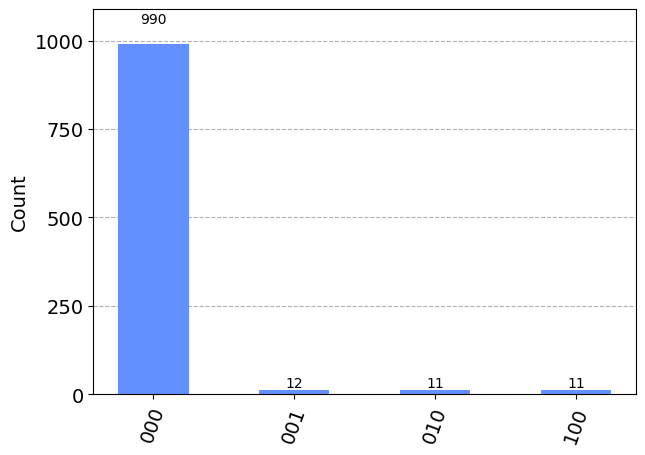

In [6]:
qc0 = QuantumCircuit(3)  # initialize circuit with three qubits in the 0 state
qc0.measure_all()  # measure the qubits

# run the circuit with the noise model and extract the counts

counts = execute(qc0, aer_sim, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

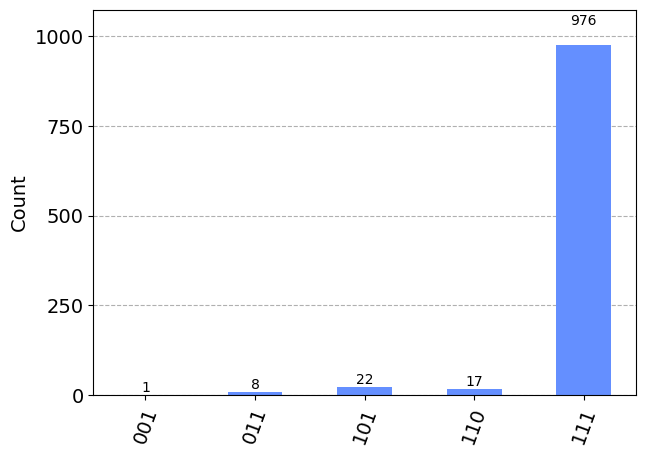

In [7]:
qc1 = QuantumCircuit(3)  # initialize circuit with three qubits in the 0 state
qc1.x([0, 1, 2])  # flip each 0 to 1

qc1.measure_all()  # measure the qubits

# run the circuit with th noise model and extract the counts
counts = aer_sim.run(qc1, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

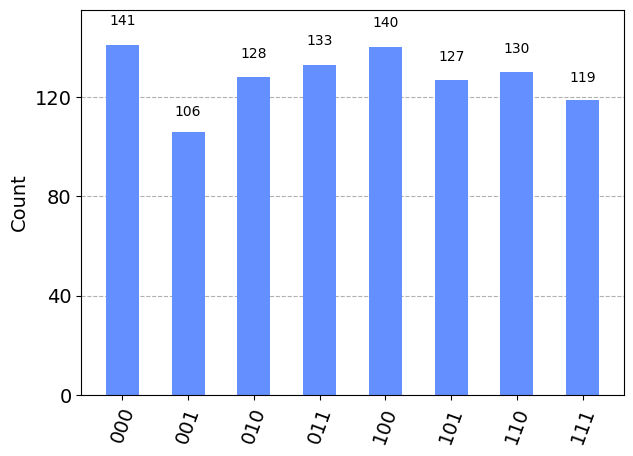

In [8]:
noise_model = get_noise(0.5, 0.0)
counts = aer_sim.run(qc1, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

In [9]:
cq = QuantumRegister(2, "code_qubit")
lq = QuantumRegister(1, "auxiliary_qubit")
sb = ClassicalRegister(1, "syndrome_bit")
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw()

code_qubit_0: ──■──────────
                   │          
   code_qubit_1: ──┼────■─────
                 ┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ┤ X ├┤ X ├┤M├
                 └───┘└───┘└╥┘
 syndrome_bit: 1/═══════════╩═
                            0

In [10]:
counts = execute(qc, aer_sim).result().get_counts()
print("Results:", counts)

Results: {'0': 1024}


In [11]:
import numpy as np
from numpy import pi, linalg, array, kron
import math

In [12]:
qc_sup = QuantumCircuit(cq)
qc_sup.ry(pi / 3, cq[0])
qc_sup.cx(cq[0], cq[1])
qc.compose(qc_sup, front=True).draw()

┌─────────┐                  
   code_qubit_0: ┤ Ry(π/3) ├──■────■──────────
                 └─────────┘┌─┴─┐  │          
   code_qubit_1: ───────────┤ X ├──┼────■─────
                            └───┘┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ────────────────┤ X ├┤ X ├┤M├
                                 └───┘└───┘└╥┘
 syndrome_bit: 1/═══════════════════════════╩═
                                            0

In [13]:
counts = aer_sim.run(qc).result().get_counts()
print("Results:", counts)

Results: {'0': 1024}


In [14]:
qc_diff = QuantumCircuit(cq)
qc_diff.h(cq[0])
qc_diff.cx(cq[0], cq[1])
qc_diff.x(cq[0])
qc.compose(qc_diff, front=True).draw()

┌───┐     ┌───┐             
   code_qubit_0: ┤ H ├──■──┤ X ├──■──────────
                 └───┘┌─┴─┐└───┘  │          
   code_qubit_1: ─────┤ X ├───────┼────■─────
                      └───┘     ┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ───────────────┤ X ├┤ X ├┤M├
                                └───┘└───┘└╥┘
 syndrome_bit: 1/══════════════════════════╩═
                                           0

In [15]:
qc2 = qc.compose(qc_diff, front=True)
counts = aer_sim.run(qc2).result().get_counts()
print("Results:", counts)

Results: {'1': 1024}


# PART 2

In [ ]:
from qiskit.ignis.verification.topological_codes import RepetitionCode

/var/folders/mt/y75db3512zv_8r60rn4pb82h0000gn/T/ipykernel_35006/346130200.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.topological_codes import RepetitionCode


In [17]:
n = 3
T = 1
code = RepetitionCode(n, T)

In [18]:
code.circuit["1"].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ─────┤ X ├─────┤ X ├────────┤M├─────────
                         └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ───────┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                    ┌───┐  │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ┤ X ├──■────┼────┼────┼──┤M├─╫──╫───────
                    ├───┤       │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ┤ X ├───────■────■────┼───╫──╫──╫─┤M├───
                    ├───┤                 │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ┤ X ├─────────────────■───╫──╫──╫──╫─┤M├
                    └───┘                     ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/══════════════════════════╬══╩══╩══╬══╬═
                                              ║  0  1  ║  ║ 
        code_bit: 3/══════════════════════════╩════════╩══╩═
                                              0        1  2

In [19]:
def get_raw_results(code, noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for i in range(2):
        qobj = assemble(circuits[i])
        job = execute(circuits[i], aer_sim, noise_model=noise_model, shots=10)
        raw_results[str(i)] = job.result().get_counts(str(i))
    return raw_results


raw_results = get_raw_results(code)
for i in raw_results:
    print("Logical", i, ":", raw_results[i], "\n")

Logical 0 : {'000 00': 10} 

Logical 1 : {'111 00': 10} 



In [20]:
code = RepetitionCode(3, 1)

noise_model = get_noise(0.01, 0.5)

raw_results = get_raw_results(code, noise_model)
for log in raw_results:
    print("Logical", log, ":", raw_results[log], "\n")

Logical 0 : {'000 00': 2, '100 00': 1, '100 01': 1, '011 00': 1, '010 01': 2, '001 00': 1, '000 01': 2} 

Logical 1 : {'111 11': 1, '001 10': 1, '001 11': 1, '010 10': 1, '011 00': 1, '011 10': 3, '101 00': 1, '111 01': 1} 



In [21]:
from qiskit.ignis.verification.topological_codes import lookuptable_decoding

In [25]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = execute(circuits[log], aer_sim, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

In [ ]:
P = lookuptable_decoding(table_results, raw_results)
print("P =", P)

P = {'0': 0.1, '1': 0.1}
